# **The Navier-Stokes equations**
**Johan Hoffman**

**Lab made by:** Frida Svelander, \\
**In collaboration with:** Joel Kronborg

# **Abstract**

In this short report I present my solution to the lab on the Navier-Stokes equations in the course DD2365/FDD3371 Advanced Computation in Fluid Mechanics at KTH Royal Institute of Technology. I have used the FEniCS software with Python in Google Colab to solve a set of problems related to the Reynolds number, drag and lift forces on a circular cylinder in 2D channel flow. 

The weak form of the Navier-Stokes equations are discretized using a stabilized space-timne finite element method. The force on the cylinder in the direction of the inflow (drag force) and perpendicular to the inflow (lift force) is calculated at different Reynolds number (different viscosities). We investigate the relationship between the Reynolds number and the formation of a von Karman Vortex street, and compute the Strouhal number of the flow. 

The solution is visualized using FEniCS plotting functions and exported and visualized in Paraview. 

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0, (1)$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v), (2)$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

We use FEniCS with Python in Google Colab to solve the Navier-Stokes equations in 2D channel flow using a finite element method. We  first define and load the necessary Python modules to use the FEniCS software. Then we define the domain, mesh and equations, and solve these using an iterative time-stepping method.

**Load the FEniCS environment**

In [76]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS
try:
    import dolfin
except ImportError as e:
    !apt-get install -y -qq software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    !sed -i "s|#if PETSC_VERSION_MAJOR == 3 && PETSC_VERSION_MINOR <= 8 && PETSC_VERSION_RELEASE == 1|#if 1|" /usr/include/dolfin/la/PETScLUSolver.h
    !rm -rf /usr/lib/python3/dist-packages/mpi4py*
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/dolfin*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=1cT_QBJCOW_eL3BThnval3bcpb8o0w-Ad" -O /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-3qY4VIJQaXVO1HfGQIzTIURIeJbvX-9" -O /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/mpi4py-2.0.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/fenics_dolfin-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

**Define domain and mesh**

We first define the triangle mesh with resolution h=1/32 and a circular hole of radius 0.2 at the vertical center of the channel, but closer to the inlet in the horizontal direction to simulate the vortex street behind the cylinder. We plot the mesh and see the result in Fig. 1.

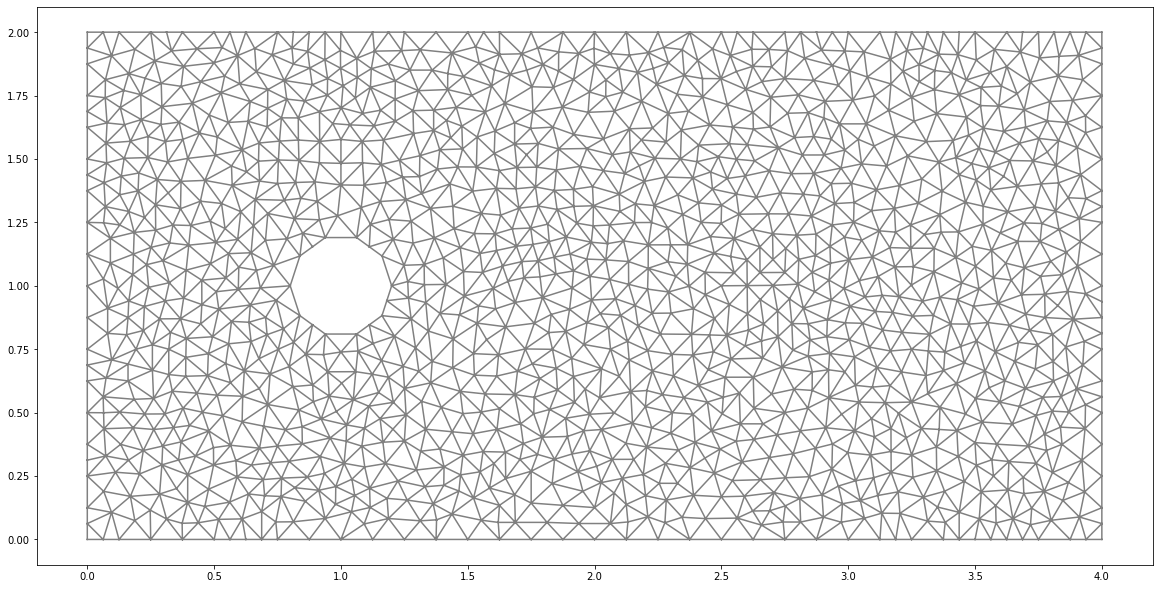

In [77]:
# Define rectangular domain 
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2
rd = 2*rc # diameter of cylinder

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0) 

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)
      
left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 32 # 8, 16, 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 1.0:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)

plt.figure(figsize=(20, 16))
plot(mesh)
plt.show()

**Fig 1.** The 2D channel domain of size 4x2 units, discretized with uniform triangle size 1/32. A circular cylinder of radius 0.2 is located at x=1.0, y=1.0. 

**Define finite element approximation spaces**

Next, we define the finite element spaces on which we seek the solution to the variational formulation of the Navier-Stokes equations. We choose piecewise continuous linear function spaces for as well the velocity as the pressure. To make the method stable at high Reynolds numbers (transport dominated flow), an artificial viscosity is later added. See J. Hoffman, *Lecture Notes in Advanced Computation in Fluid Dynamics*, pp. 71-72, for a more in depth description of the stabilized finite element method. 

In [78]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

Next we define the bouncary conditions for the Navier-Stokes problem (1)-(2). We set the inflow velocity to $1$m/s, and the pressure reference at the outlet boundary is set to zero. The velocity at the channel walls and at the cylinder boundary is set to 0 (no-slip condition). 

In [79]:
# Define boundary conditions 
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0) 

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left) 
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration  
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

**Define flow parameters**

We introduce a vector $\texttt{nu_v}$ to hold the four different viscosities needed to simulate the problem at Reynolds number $Re=1,10,100,1000$. The Reynolds number is calculated as $Re =\frac{U*D}{\nu}$, where $U=1$ is the inflow velocity, $D=0.4$ is the diameter of the cylinder and the characteristic length scale of the problem. 

In [80]:
# Set viscosity
nu_v = [4.0e-1, 4.0e-2, 4.0e-3, 4.0e-4] # modify reynolds number by changing viscosity
nu = nu_v[2] # 4.0e-3 #re = 1 stabilt - kraft i y-riktningen stabiliserar sig 
# look for karman vortex street, unsteady flow <-> force varies <-> creates vortex street
# re = 1000, force is exchangeably positive and negative and a vortex street is created
# re = 1.0, 10.0 is stable, 10.0 stabilizes after around 5s
# re = 100, 1000 generates a vortex street

# Compute Reynolds number
re = uin*rd/nu
print(re)

100.0


**Define method parameters**

We define functions for the old and new velocity $u_0, u_1$ and pressure $p_0, p_1$ to be used in the time stepping of the transient problem. We set solver parameters and the time step size $dt=0.5h_{min}$, where $h_{min}$ is a measure of the smallest cell size in the mesh. 

In [81]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step  
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers 
num_nnlin_iter = 5 
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

# Time step length 
dt = 0.5*mesh.hmin() 

**Define variational problem**

Then we define the variational formulation of the Navier-Stokes problem (1)-(2). We have one form for the velocity and one for the pressure. 

In [82]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx 
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx 
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

We define an expression to keep track of the part of the mesh that is located at the boundary of the circular hole, where the drag and lift forces are calculated. When $\texttt{phi_x}=1.0$ and $\texttt{phi_y}=0.0$, the drag force is calculated. Conversely, when $\texttt{phi_x}=0.0$ and $\texttt{phi_y}=1.0$, the lift force on the cylinder is calculated. A normalization parameter is introduced to calculate the drag and lift coefficients. 

In [83]:
# Define the direction of the force to be computed 
phi_x = 0.0
phi_y = 1.0

#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

Force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

#plt.figure()
#plot(psi, title="weight function psi")

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [84]:
# Open files to export solution to Paraview
file_u = File("results-NS/u.pvd")
file_p = File("results-NS/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 30

# Force computation data 
force_array = np.array(0.0)
force_array = np.delete(force_array, 0)
time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

An iterative time stepping method is implemented to solve for the non-linear equations. We solve from time t=0.0 to t=30.0, a linear system of equations five times for each time step to iterate a feasible solution for the velocity and pressure fields. At each iteration, the linear system of equations is assembled from the variational formulation, and new boundary conditions are calculated from the previous iteration. 

Time t = 0.03285506167650246


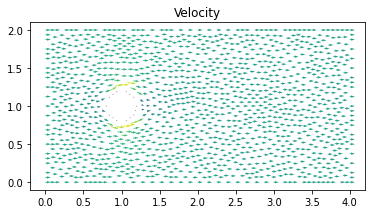

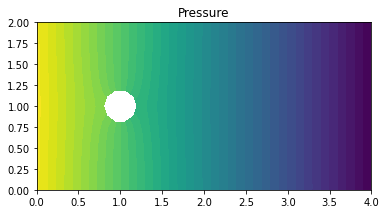

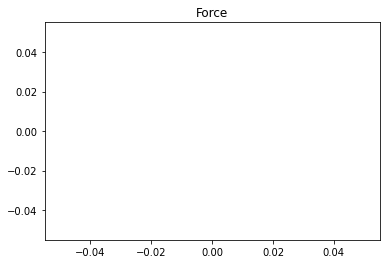

Time t = 1.018506911971576


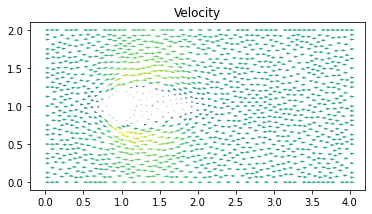

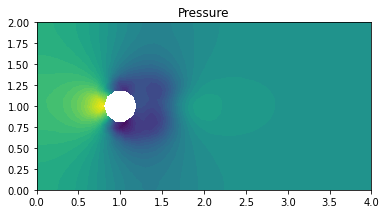

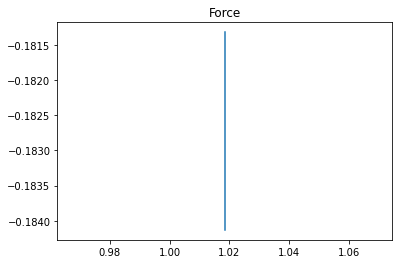

Time t = 2.004158762266649


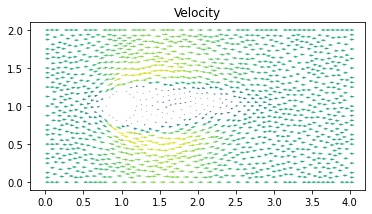

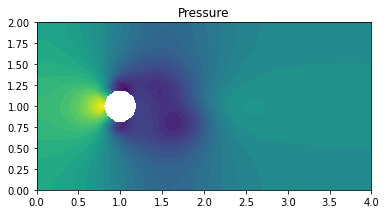

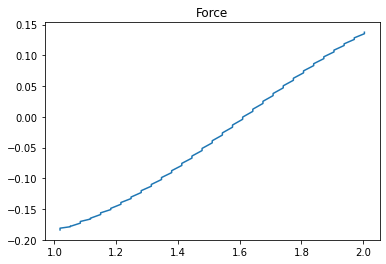

Time t = 3.022665674238231


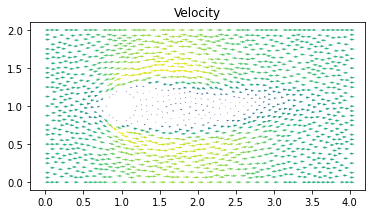

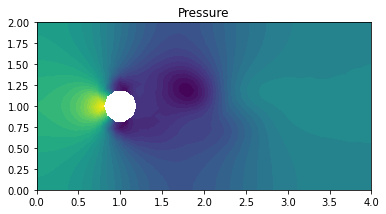

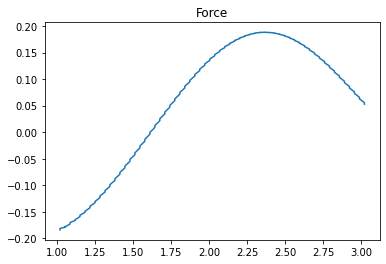

Time t = 4.00831752453331


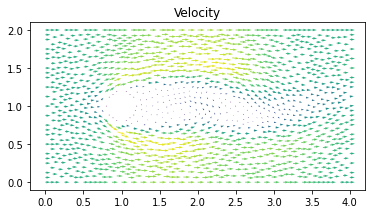

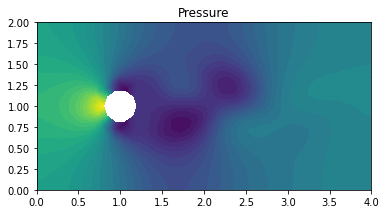

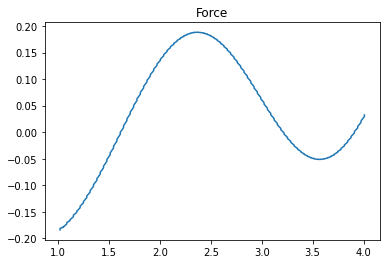

Time t = 5.026824436504892


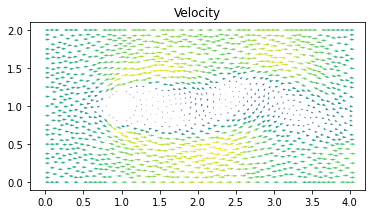

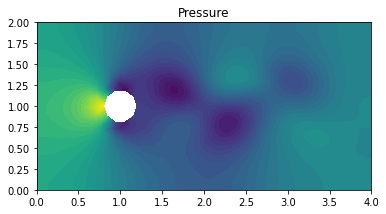

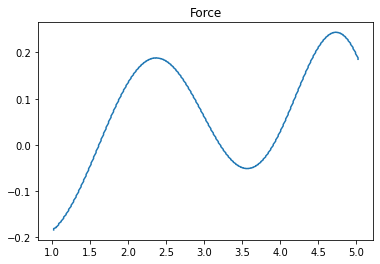

Time t = 6.012476286799972


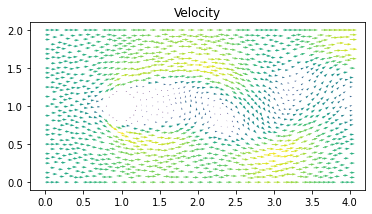

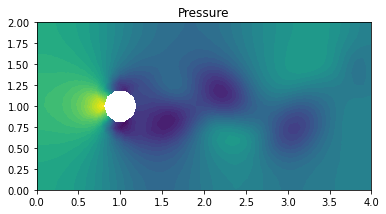

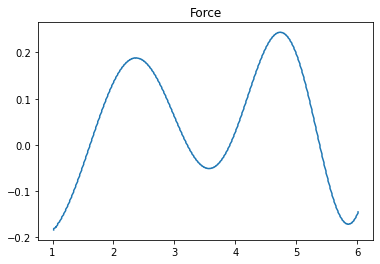

Time t = 7.030983198771554


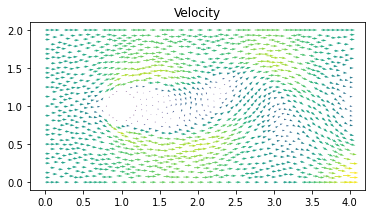

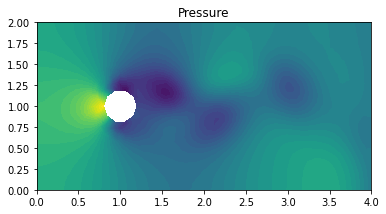

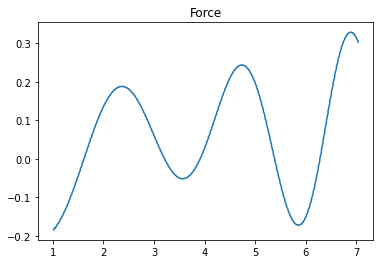

Time t = 8.016635049066632


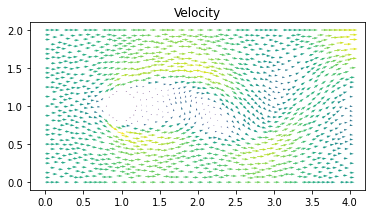

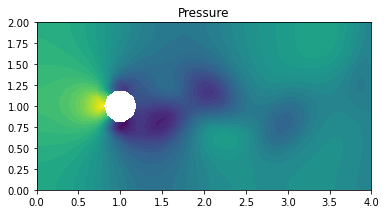

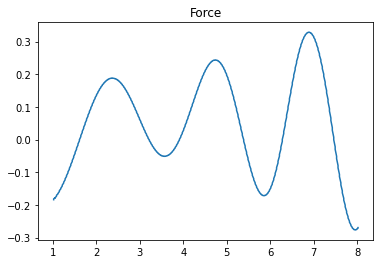

Time t = 9.002286899361685


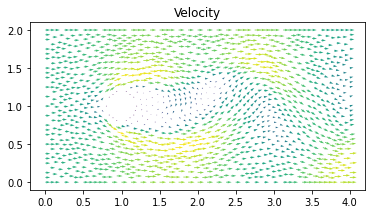

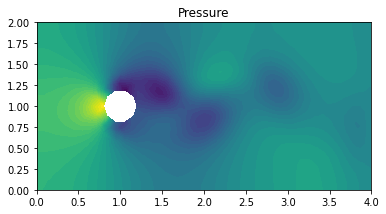

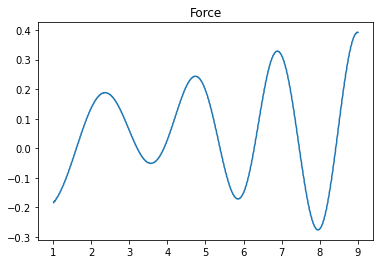

Time t = 10.02079381133324


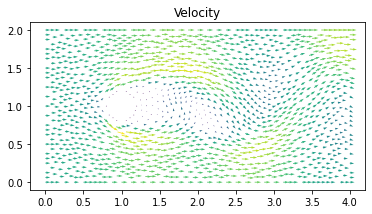

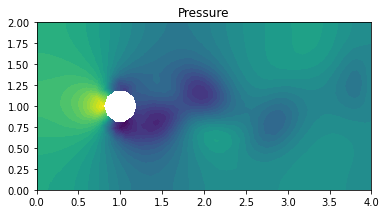

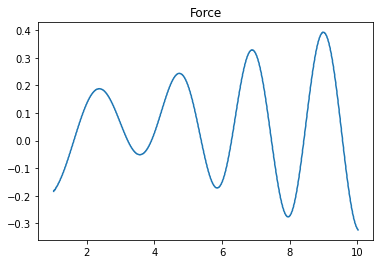

Time t = 11.006445661628293


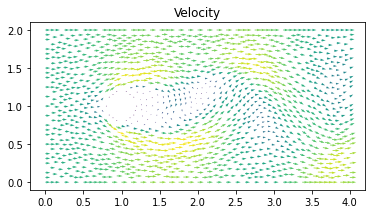

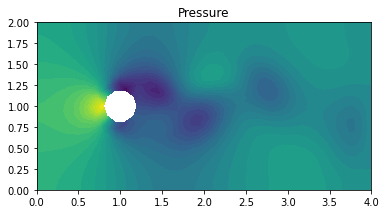

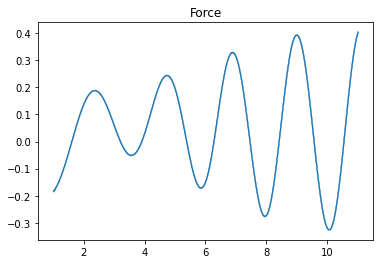

Time t = 12.024952573599847


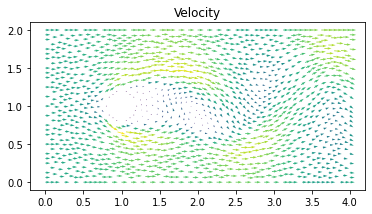

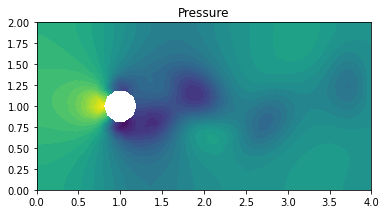

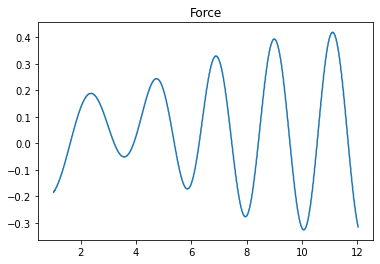

Time t = 13.0106044238949


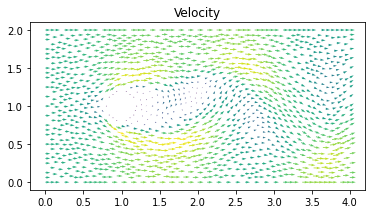

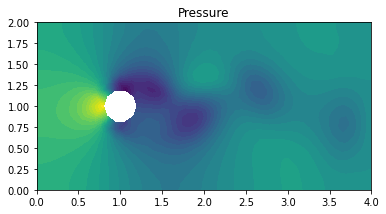

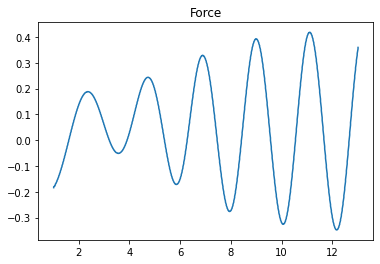

Time t = 14.029111335866455


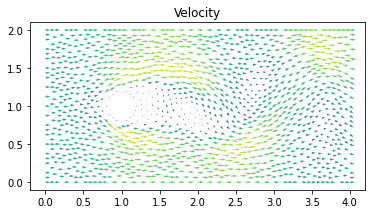

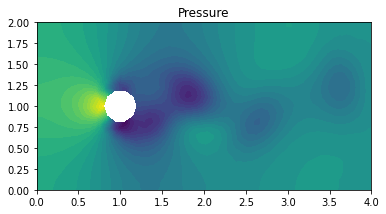

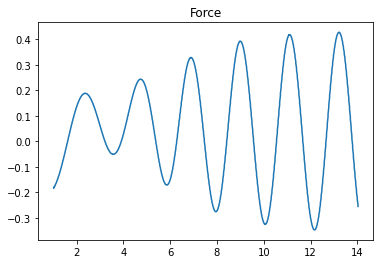

Time t = 15.014763186161508


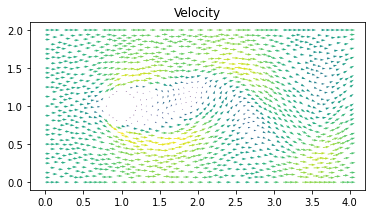

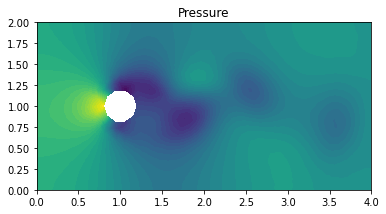

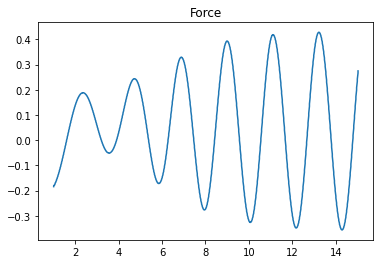

Time t = 16.000415036456562


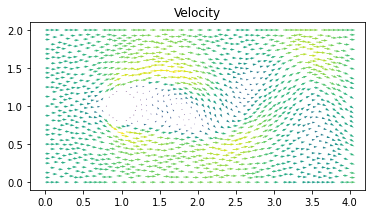

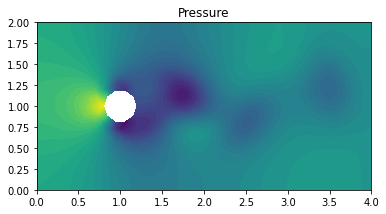

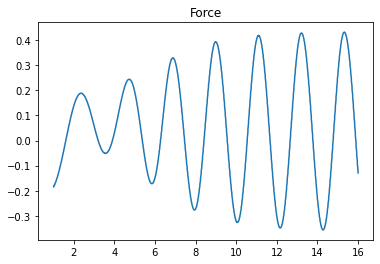

Time t = 17.018921948428172


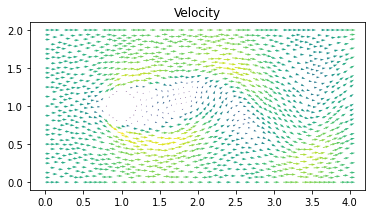

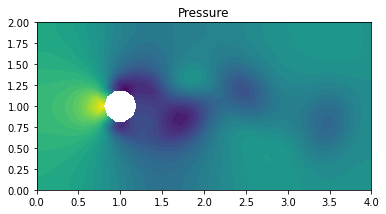

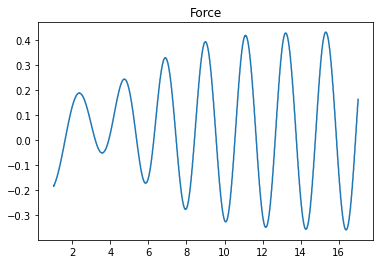

Time t = 18.00457379872328


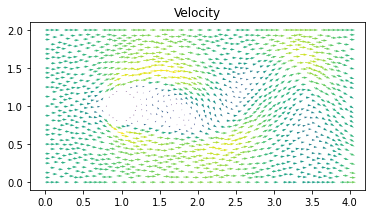

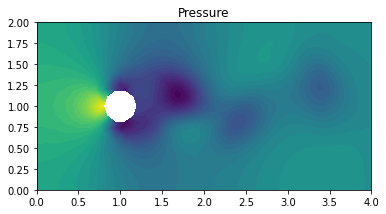

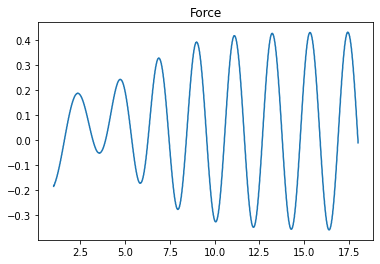

Time t = 19.023080710694888


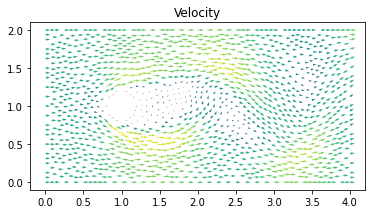

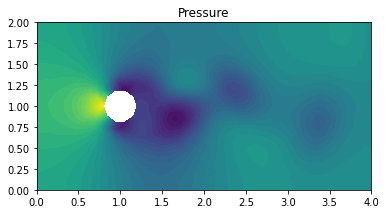

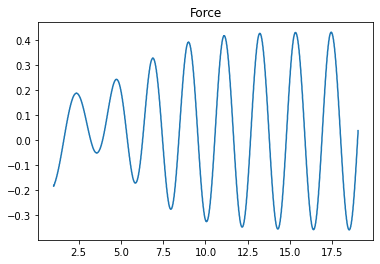

Time t = 20.008732560989994


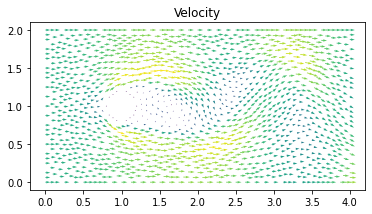

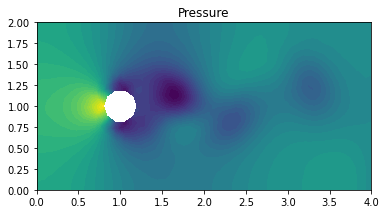

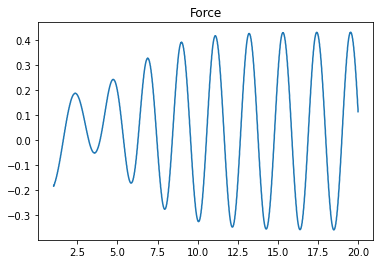

Time t = 21.027239472961604


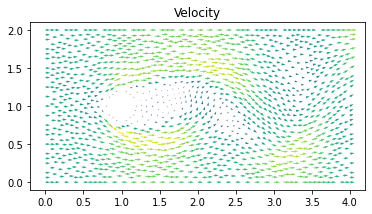

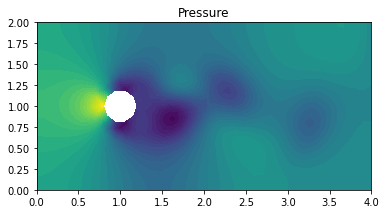

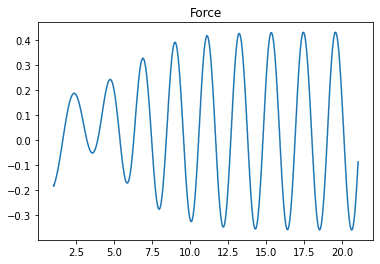

Time t = 22.01289132325671


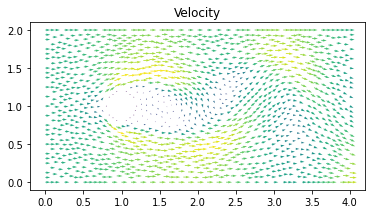

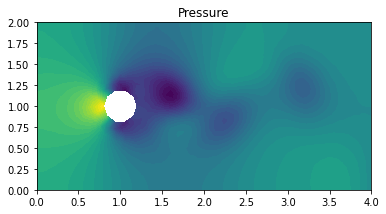

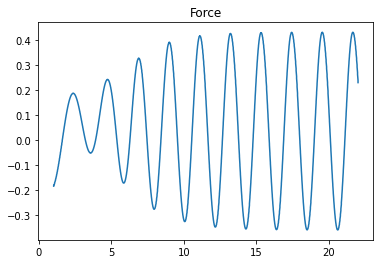

Time t = 23.03139823522832


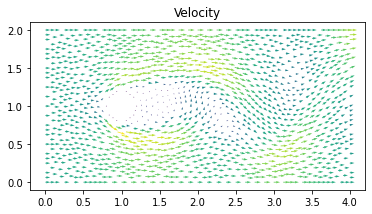

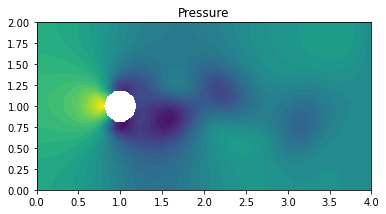

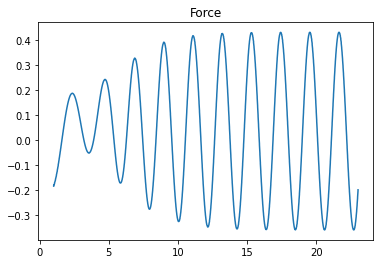

Time t = 24.017050085523426


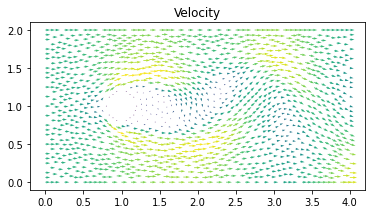

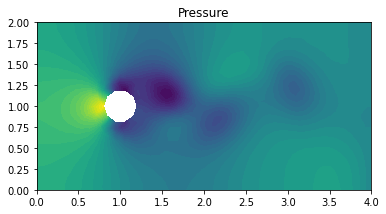

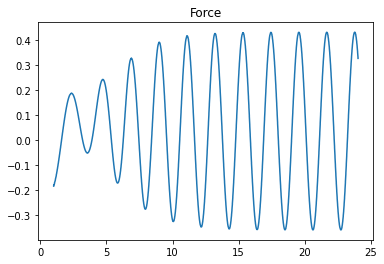

Time t = 25.002701935818532


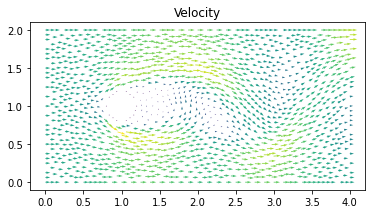

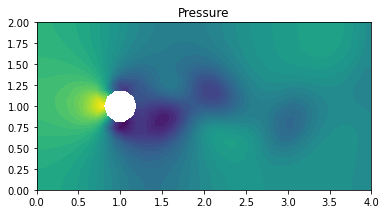

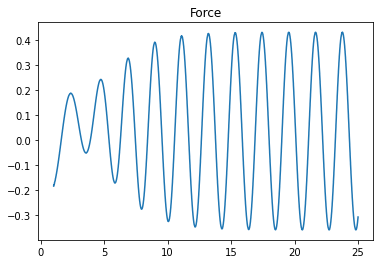

Time t = 26.02120884779014


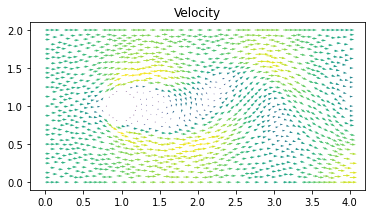

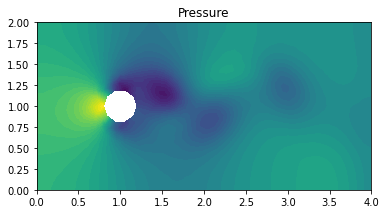

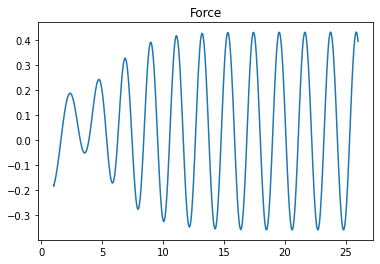

Time t = 27.006860698085248


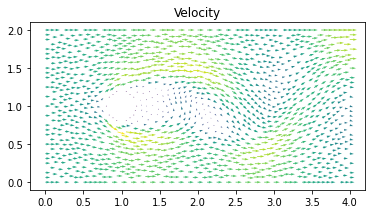

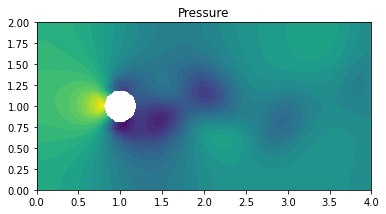

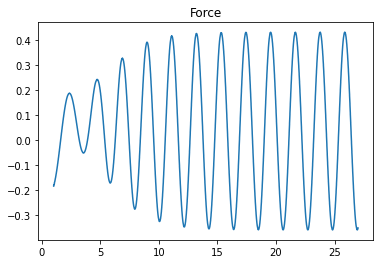

Time t = 28.025367610056858


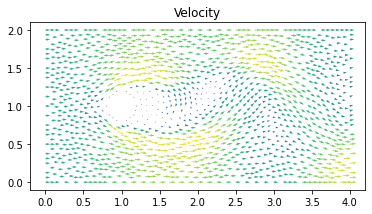

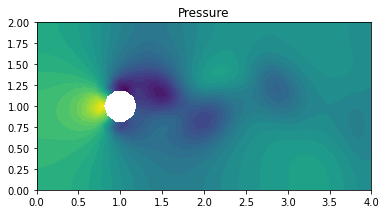

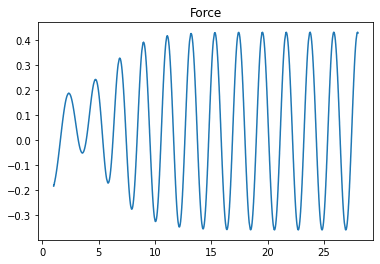

Time t = 29.011019460351964


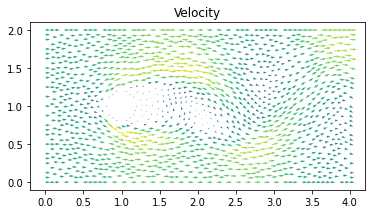

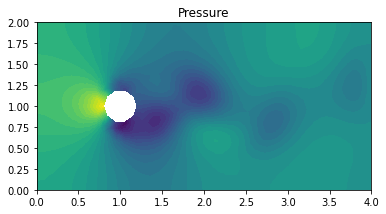

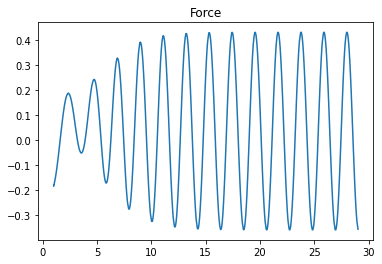

results-NS/
results-NS/u000001.vtu
results-NS/p000000.vtu
results-NS/p000009.vtu
results-NS/u000028.vtu
results-NS/u000025.vtu
results-NS/u000010.vtu
results-NS/p000015.vtu
results-NS/u000000.vtu
results-NS/p000021.vtu
results-NS/p000001.vtu
results-NS/p000006.vtu
results-NS/u000013.vtu
results-NS/p000010.vtu
results-NS/u000016.vtu
results-NS/p000023.vtu
results-NS/p000027.vtu
results-NS/u000011.vtu
results-NS/p000024.vtu
results-NS/u000029.vtu
results-NS/u000007.vtu
results-NS/u000027.vtu
results-NS/p000025.vtu
results-NS/p000004.vtu
results-NS/p000022.vtu
results-NS/p000007.vtu
results-NS/u000024.vtu
results-NS/u000002.vtu
results-NS/p000014.vtu
results-NS/u000004.vtu
results-NS/u000023.vtu
results-NS/u000017.vtu
results-NS/p000029.vtu
results-NS/p000016.vtu
results-NS/u.pvd
results-NS/u000020.vtu
results-NS/u000015.vtu
results-NS/p000003.vtu
results-NS/p000017.vtu
results-NS/p000008.vtu
results-NS/p000026.vtu
results-NS/p000020.vtu
results-NS/u000006.vtu
results-NS/u000005.vtu
resul

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
!rm results-NS/*

# Time stepping 
T = 30
t = dt
while t < T + DOLFIN_EPS:

    #s = 'Time t = ' + repr(t) 
    #print(s)

    pin.t = t
    #uin.t = t

    # Solve non-linear problem 
    k = 0
    while k < num_nnlin_iter: 
        
        # Assemble momentum matrix and vector 
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution 
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap) 
        bp = assemble(Lp)

        # Compute pressure solution 
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F = assemble(Force)
        if (t > start_sample_time):
          force_array = np.append(force_array, normalization*F)
          time = np.append(time, t)

        k += 1

    if t > plot_time:     
        
        s = 'Time t = ' + repr(t) 
        print(s)
    
        # Save solution to file
        file_u << u1
        file_p << p1

        # Plot solution
        plt.figure()
        plot(u1, title="Velocity")

        plt.figure()
        plot(p1, title="Pressure")

        plot_time += T/plot_freq
        
        plt.show()

        plt.figure()
        plt.title("Force")
        plt.plot(time, force_array)
        plt.show()

    # Update time step
    u0.assign(u1)
    t += dt

!tar -czvf results-NS.tar.gz results-NS
files.download('results-NS.tar.gz')

# **Results** 

We present results in terms of flow and pressure fields computed at different Reynolds number. We compute and compare drag and lift coefficients as well as the Strouhal number, and verify that the von Karman vortex street has a Stouhal number of 0.2. Further, for $Re=100$, we  compute the flow and pressure fields for mesh resolutions $h=1/8, 1/16, 1/32$, and compare the drag and lift force and the Strouhal number for different mesh resolutions. 



In [86]:
# Flow parameters needed for drag and lift force calculations
rho = 1.0 # density
U = uin
D = rd 


**Reynolds number** 

The Reynolds number $Re =\frac{UD}{\nu}$ is varied between  $Re =1, 10, 100, 1000$ by letting the dynamic viscosity $\nu$ vary between $\nu=4\cdot10^{-1}, 4\cdot10^{-2}, 4\cdot10^{-3}, 4\cdot10^{-4}$. By investigating the velocity field and the force, we see that the flow is steady and the lift force is constant for $Re=1, 10$, while an unsteady von Karman vortex street is generated at $Re=100, 1000$. See Fig. 1-2.

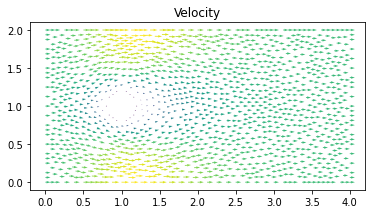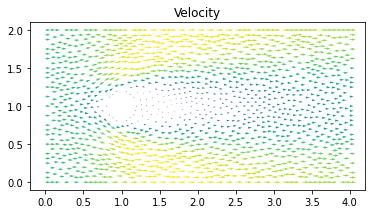
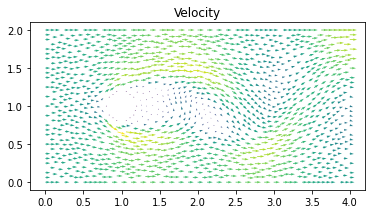 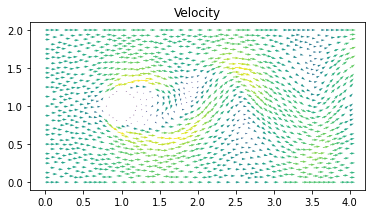

**Fig. 1.** Velocity field at t=27s for Re=1 (top left), Re=10 (top right), Re=100 (bottom left), Re=1000 (bottom right). The mesh resolution is h=1/32.  
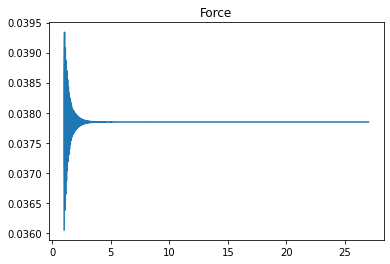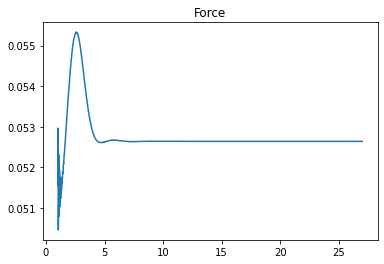
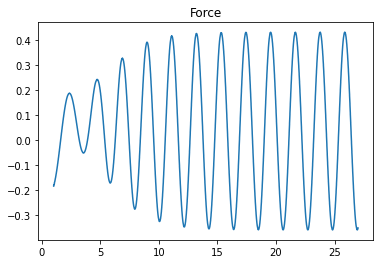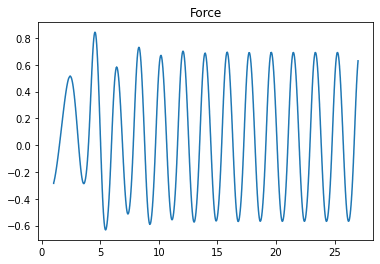

**Fig. 2.** Vertical force component (lift force) as a function of time at Re=1 (top left), Re=10 (top right), Re=100 (bottom left), Re=1000 (bottom right). The mesh resolution is h=1/32.



**Drag force**

The drag coefficient is calculated by averaging over the last 10 time steps (t=20, 21, ..., 29 s) in the simulation, when the flow has stabilized. The computation as well as the resulting drag coefficients at different Reynolds numers are presented in the code below. We see that the drag coefficient is smaller for larger Reynolds numbers/lower viscosity. This indicates that the more unsteady flow the smaller drag force/drag coefficient.


In [87]:


# Drag force estimated as the mean of the horisontal force component acting on 
# the circular cylinder over the 10 last time steps, when the flow has stabilized 
FD = np.mean(force_array[-11:-1])
CD = 2*FD/(rho*U*U*D) # drag coefficient

print("Re: ", re, "Drag: ", CD, "Resolution: ", resolution) 

# Re:  1.0 Drag:  88.5793628523903, Resolution: 32 # viscosity is highest
# Re:  10.0 Drag:  18.029091269509056 Resolution:  32
# Re:  100.0 Drag:  8.796805816368117, Resolution:  32
# Re:  1000.0 Drag:  7.593002812417421, Resolution: 32 # viscosity is lowest


Re:  100.0 Drag:  2.021876909931482 Resolution:  32


**Lift force**

The lift coefficient is calculated by averaging over the last 10 time steps (t=20, 21, ..., 29 s) in the simulation, when the flow has stabilized. The computation as well as the resulting lift coefficients at different Reynolds numers are presented in the code below. We see that the lift coefficient is larger in magnitude for larger Reynolds numbers/lower viscosity. This indicates that the more unsteady flow the larger lift force/lift coefficient.  

In [88]:
# Lift force estimated as the mean of the vertical force component acting on the 
# circular cylinder over the 10 last time steps, when the flow has stabilized 
FL = np.mean(force_array[-11:-1]) # lift force
CL = 2*FL/(rho*U*U*D)# lift coefficient

print("Re: ", re, "Lift: ", FL, "Resolution: ", resolution) 

# Re:  1.0 Lift:  0.03784496817208407 Resolution:  32
# Re:  10.0 Lift:  0.052640108368615546 Resolution:  32
# Re:  100.0 Lift:  0.4043753819862964, Resolution: 32
# Re:  1000.0 Lift:  -0.5667111474177287, Resolution: 32



Re:  100.0 Lift:  0.4043753819862964 Resolution:  32



**Strouhal number**

The Stouhal number $St=\frac{fD}{U}$, where $f$ is the frequency of vortex shedding, D is the diameter of the cylinder and $U$ is the characteristic velocity is calculated by estimating the frequency of the vortex shedding by eye from the lift force (see Fig. 2) from time approximately t=20 to t=30s, when the flow has stabilized. For Re=100 and Re=1000, $f$ is estimated to 0.5/s. With a characteristic length scal $D=0.4$ and characteristic velocity $U=1$, the Strouhal number for the vortex street is estimated to 0.2, as expected. 


In [89]:

# Strouhal number St = fU/L
# Re 1000
f_1000 = 0.5 # approx. estimation from the force plot at t=27
St_1000 = f_1000*rd/U
print("St_1000: ", St_1000)
# St_1000:  0.2

# Re 100
f_100 = 0.5 # approx. estimation from the force plot at t=27
# f_100_16 = 0.4
St_100 = f_100*rd/U
print("St_100: ", St_100, "Resolution: ", resolution)

# St_100:  --   Resolution:  8
# St_100:  0.16 Resolution: 16, almost converged
# St_100:  0.2  Resolution: 32, converged

# Re 10
f_10 = 0.5 # approx. estimation from the force plot at t=27
St_10 = f_10*rd/U
print("St_10: ", St_10)

# Re 1
f_1 = 0.5 # approx. estimation from the force plot at t=27
St_1 = f_1*rd/U
print("St_1: ", St_1)

St_1000:  0.2
St_100:  0.2 Resolution:  32
St_10:  0.2
St_1:  0.2



**Mesh resolution**

A mesh convergence study is performed by varying the mesh reolution $h=1/8, 1/16, 1/32$, to be compared with the above studies for $h=1/32$. The resulting pressure fields are seen in Fig. 3. It is obvious from the figure that the mesh is not fine enough for $h=1/16$ and $h=1/8$. For $h=1/16$ the vortex street can be discerned, but it is not close to the resolution for $h=1/16$. This means the solutions for $h$ larger than 1/32 are not converged. 

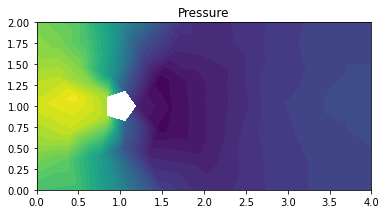
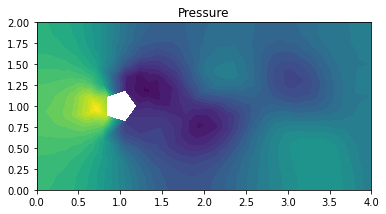
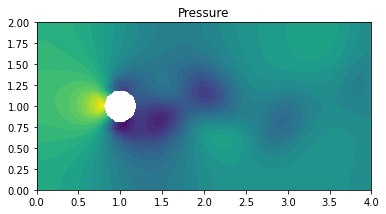

We estimate the Strouhal number for the vortex street at $h=1/16$ to 0.16, which is not close enough to 0.2 to assume convergence. See Fig. 4. for the lift force at Re=100, h=1/16. The Strouhal number for h=1/8 is not applicable since there is no vortex street with a shedding frequency. 

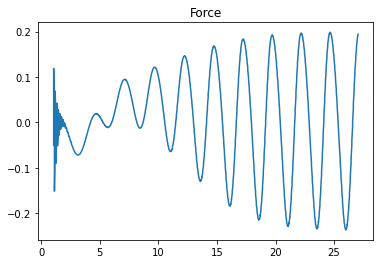

**Fig. 4.** Lift force at Re=100, h=1/16. The frequency of vortex shedding is estimated to 0.4/s.

Results from the calculation of lift and drag coefficients at different mesh size is found below. 

In [90]:

# Re:  100.0 Lift:  0.14725388250255272 Resolution:  16
# Re:  100.0 Lift:  0.4043753819862964, Resolution: 32

# Re:  100.0 Drag:  14.948038173436474 Resolution:  8, NA, too coarse mesh
# Re:  100.0 Drag:  10.44248122056373 Resolution:  16
# Re:  100.0 Drag:  6.749539522024809 Resolution:  64

# **Extra assignment**

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution. A von Karman vortex street developed as expected for Re=100 and Re=1000, but the flow for Re=1, 10 is steady.(https://en.wikipedia.org/wiki/Kármán_vortex_street). 

We have calculated drag, lift and Strouhal numbers for different Reynolds numbers and different mesh sizes. The lift coefficient increases with increasing Reynolds number, while the drag coefficient decreases the less viscous the flow is. We show that mesh size needs to be at least h=1/32 for the solution to be physically correct.
  